# GRU 302
Start with GRU 301 which did train on long, test on short.
Here train on short, test on long.

In [1]:
TRAIN_NC_FILENAME='ncRNA.gc36.short.fasta'
TRAIN_PC_FILENAME='pcRNA.gc36.short.fasta'
VALID_NC_FILENAME='ncRNA.gc36.long.fasta'
VALID_PC_FILENAME='pcRNA.gc36.long.fasta'
#NC_FILENAME='ncRNA.tiny50.fasta'
#PC_FILENAME='pcRNA.tiny50.fasta'
#NC_FILENAME='ncRNA.gc34.processed.fasta'
#PC_FILENAME='pcRNA.gc34.processed.fasta'

MODEL_FILE='JUNK2'  # change this if you want to keep models
DATAPATH=''

try:
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"
TRAIN_NC_FILENAME = DATAPATH+TRAIN_NC_FILENAME
TRAIN_PC_FILENAME = DATAPATH+TRAIN_PC_FILENAME
VALID_NC_FILENAME = DATAPATH+VALID_NC_FILENAME
VALID_PC_FILENAME = DATAPATH+VALID_PC_FILENAME
MODEL_FILE=DATAPATH+MODEL_FILE

EPOCHS=200
SPLITS=5
ONEHOT=5  
NEURONS=64
DROP=0.10
ACT="tanh"
MINLEN=201
MAXLEN=2000
LIMIT=5588    # This is the size of our smallest set (protein coding short)

Mounted at /content/drive/


In [2]:
# Load our own tools
# TO DO: don't go to GitHub if the file is already local.
GITHUB = True
if GITHUB:
    #!pip install requests  # Uncomment this if necessary. Seems to be pre-installed.
    import requests
    r = requests.get('https://raw.githubusercontent.com/ShepherdCode/ShepherdML/master/Strings/tools_fasta.py')
    with open('tools_fasta.py', 'w') as f:
        f.write(r.text)
    # TO DO: delete the file after import
import tools_fasta as tools
tools.yahoo()  # If this prints "Yahoo!" the the import was successful.

TOOLS_CHANGED = False   # set to True to re-run with a new version of tools
if TOOLS_CHANGED:
  from importlib import reload 
  tools=reload(tools)
  print(dir(tools))   # run this to see EVERYTHING in the tools module

Yahoo!


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
import time
dt='float32'
tf.keras.backend.set_floatx(dt)

Build model

In [4]:
def compile_model(model):
    ## learn rate = initial_learning_rate * decay_rate ^ (step / decay_steps)
    #adam_default_learn_rate = 0.001
    #schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    #    initial_learning_rate = adam_default_learn_rate*10,
    #    decay_steps=10000, decay_rate=0.99, staircase=True)
    #alrd = tf.keras.optimizers.Adam(learning_rate=schedule)
    #model.compile(loss=bc, optimizer=alrd, metrics=["accuracy"])

    print("COMPILE...")
    bc=tf.keras.losses.BinaryCrossentropy(from_logits=False)
    model.compile(loss=bc, optimizer="adam", metrics=["accuracy"])
    print("...COMPILED")
    return model

def build_model():
    MASK=[0,0,0,0,1] # to do: get one_hot('N') from the one_hot() function.
    mask_layer = keras.layers.Masking(mask_value=MASK, input_shape=[MAXLEN,ONEHOT])
    rlayer1 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP )  
    rlayer2 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer3 = keras.layers.GRU(NEURONS, return_sequences=True, 
        activation=ACT, dropout=DROP) 
    rlayer4 = keras.layers.GRU(NEURONS, return_sequences=False, 
        activation=ACT, dropout=DROP) 

    dlayer1 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer2 = keras.layers.Dropout(DROP)
    dlayer3 = keras.layers.Dense(NEURONS, activation=ACT,dtype=dt)
    dlayer4 = keras.layers.Dropout(DROP)
    output_layer = keras.layers.Dense(1, activation="sigmoid", dtype=dt)

    rnn = keras.models.Sequential()
    rnn.add(mask_layer)
    rnn.add(rlayer1)
    rnn.add(rlayer2)
    rnn.add(rlayer3)
    rnn.add(rlayer4)
    rnn.add(dlayer1)
    rnn.add(dlayer2)
    rnn.add(dlayer3)
    rnn.add(dlayer4)
    rnn.add(output_layer)
    compiled = compile_model(rnn)
    return compiled

Cross validation

In [5]:
def do_cross_validation(X_train,y_train,given_model,X_valid,y_valid):
    cv_scores = []
    fold=0
    # When not using ShuffleSplit, make sure to randomize train data.
    #splitter = ShuffleSplit(n_splits=SPLITS, test_size=0.1, random_state=37863)
    #for train_index,valid_index in splitter.split(X):
    while fold < SPLITS:
        fold += 1
        # Avoid continually improving the same model.
        model = compile_model(keras.models.clone_model(given_model))
        bestname=MODEL_FILE+".cv."+str(fold)+".best"
        es = keras.callbacks.EarlyStopping(monitor='val_loss',  
            patience=10, verbose=1)
        mc = keras.callbacks.ModelCheckpoint(
            filepath=bestname, save_best_only=True, 
            monitor='val_accuracy', mode='max')  
        mycallbacks = [es,mc]  
        print("FIT")
        start_time=time.time()
        history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                epochs=EPOCHS, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                callbacks=mycallbacks, shuffle=True,
                validation_data=(X_valid,y_valid) )
        end_time=time.time()
        elapsed_time=(end_time-start_time)                        
        print("Fold %d, %d epochs, %d sec"%(fold,EPOCHS,elapsed_time))
        pd.DataFrame(history.history).plot(figsize=(8,5))
        plt.grid(True)
        plt.gca().set_ylim(0,1)
        plt.show()
        best_model=keras.models.load_model(bestname)
        scores = best_model.evaluate(X_valid, y_valid, verbose=0)
        print("%s: %.2f%%" % (best_model.metrics_names[1], scores[1]*100))
        cv_scores.append(scores[1] * 100)  

    print()
    print("%d-way Cross Validation max %.2f%%, mean %.2f%% (+/- %.2f%%)" % 
          (fold, np.amax(cv_scores), np.mean(cv_scores), np.std(cv_scores)))

## Train on RNA lengths 200-1Kb

In [6]:
print ("Compile the model")
model=build_model()
print ("Summarize the model")
print(model.summary())  # Print this only once
#model.save(MODEL_FILE+'.model')


Compile the model
COMPILE...
...COMPILED
Summarize the model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 2000, 5)           0         
_________________________________________________________________
gru (GRU)                    (None, 2000, 64)          13632     
_________________________________________________________________
gru_1 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_2 (GRU)                  (None, 2000, 64)          24960     
_________________________________________________________________
gru_3 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_____________________________________________________________

In [7]:
def load_data(nc_filename,pc_filename,limit=None):
  nc_seq=tools.load_fasta(nc_filename,0)
  pc_seq=tools.load_fasta(pc_filename,1)
  if limit is not None:
    # Choose a random subset of size = limit.
    # Side effect: randomizes the data order.
    nfrac=1.0*limit/len(nc_seq)
    pfrac=1.0*limit/len(pc_seq)
    if nfrac<1.0:
      nc_seq=nc_seq.sample(frac=nfrac)
    if pfrac<1.0:
      pc_seq=pc_seq.sample(frac=pfrac)
  train_set=pd.concat((nc_seq,pc_seq),axis=0)
  # May not need to slice by length if input files already sliced
  subset=tools.make_slice(train_set,MINLEN,MAXLEN)
  # randset=subset.sample(frac=1) # unneccessary with fit(shuffle)
  (X1,y1)=tools.separate_X_and_y(subset)
  # X1 is pandas df of ("list" of one sequence)
  X2=X1.to_numpy()  # numpy ndarray of ("list" of one sequence)
  X3=[elem[0] for elem in X2]  # numpy dnarray of str
  X4=tools.uniform_length(X3,MAXLEN)
  X5= [tools.one_hot(x) for x in X4]  
  # one-hot leaves ONEHOT=5. TO DO: set 5 automatically
  X6=np.asarray(X5)
  y6=y1.to_numpy()
  return X6,y6

print("Load train data from files.")
X_train,y_train = load_data(TRAIN_NC_FILENAME,TRAIN_PC_FILENAME,LIMIT)
print("X_train",X_train.shape)
print(X_train[1])
print("Load valid data from files.")
X_valid,y_valid = load_data(VALID_NC_FILENAME,VALID_PC_FILENAME,LIMIT)
print("X_valid",X_valid.shape)

Load train data from files.
X_train (11176, 2000, 5)
[[0 1 0 0 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 ...
 [0 0 0 0 1]
 [0 0 0 0 1]
 [0 0 0 0 1]]
Load valid data from files.
X_valid (11176, 2000, 5)


Cross valiation
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 140s 348ms/step - loss: 0.6853 - accuracy: 0.5479 - val_loss: 0.7020 - val_accuracy: 0.5211


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 2/200
350/350 [==============================] - 122s 349ms/step - loss: 0.6814 - accuracy: 0.5667 - val_loss: 0.7151 - val_accuracy: 0.5142
Epoch 3/200
350/350 [==============================] - 119s 341ms/step - loss: 0.6778 - accuracy: 0.5741 - val_loss: 0.7115 - val_accuracy: 0.5097
Epoch 4/200
350/350 [==============================] - 118s 337ms/step - loss: 0.6782 - accuracy: 0.5798 - val_loss: 0.6900 - val_accuracy: 0.5348


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 5/200
350/350 [==============================] - 119s 341ms/step - loss: 0.6763 - accuracy: 0.5840 - val_loss: 0.6839 - val_accuracy: 0.5539


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 6/200
350/350 [==============================] - 121s 347ms/step - loss: 0.6842 - accuracy: 0.5404 - val_loss: 0.6842 - val_accuracy: 0.5548


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 7/200
350/350 [==============================] - 122s 349ms/step - loss: 0.6789 - accuracy: 0.5709 - val_loss: 0.7077 - val_accuracy: 0.5148
Epoch 8/200
350/350 [==============================] - 121s 345ms/step - loss: 0.6769 - accuracy: 0.5823 - val_loss: 0.6928 - val_accuracy: 0.5447
Epoch 9/200
350/350 [==============================] - 125s 357ms/step - loss: 0.6693 - accuracy: 0.5958 - val_loss: 0.6021 - val_accuracy: 0.6870


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 10/200
350/350 [==============================] - 121s 347ms/step - loss: 0.6283 - accuracy: 0.6545 - val_loss: 0.5776 - val_accuracy: 0.7034


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 11/200
350/350 [==============================] - 123s 351ms/step - loss: 0.6109 - accuracy: 0.6717 - val_loss: 0.5382 - val_accuracy: 0.7309


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 12/200
350/350 [==============================] - 124s 355ms/step - loss: 0.5830 - accuracy: 0.6937 - val_loss: 0.5658 - val_accuracy: 0.7153
Epoch 13/200
350/350 [==============================] - 120s 344ms/step - loss: 0.5638 - accuracy: 0.7113 - val_loss: 0.5721 - val_accuracy: 0.7160
Epoch 14/200
350/350 [==============================] - 118s 338ms/step - loss: 0.5878 - accuracy: 0.6938 - val_loss: 0.5513 - val_accuracy: 0.7172
Epoch 15/200
350/350 [==============================] - 122s 348ms/step - loss: 0.5458 - accuracy: 0.7253 - val_loss: 0.5405 - val_accuracy: 0.7317


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 16/200
350/350 [==============================] - 118s 338ms/step - loss: 0.5261 - accuracy: 0.7419 - val_loss: 0.4243 - val_accuracy: 0.8010


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.1.best/assets


Epoch 17/200
350/350 [==============================] - 118s 336ms/step - loss: 0.5174 - accuracy: 0.7335 - val_loss: 0.5742 - val_accuracy: 0.6958
Epoch 18/200
350/350 [==============================] - 119s 339ms/step - loss: 0.5976 - accuracy: 0.6865 - val_loss: 0.5694 - val_accuracy: 0.7084
Epoch 19/200
350/350 [==============================] - 122s 349ms/step - loss: 0.5843 - accuracy: 0.6861 - val_loss: 0.5423 - val_accuracy: 0.7209
Epoch 20/200
350/350 [==============================] - 121s 347ms/step - loss: 0.5743 - accuracy: 0.7027 - val_loss: 0.6330 - val_accuracy: 0.6986
Epoch 21/200
350/350 [==============================] - 121s 345ms/step - loss: 0.5884 - accuracy: 0.6862 - val_loss: 0.5574 - val_accuracy: 0.7031
Epoch 22/200
350/350 [==============================] - 121s 347ms/step - loss: 0.5593 - accuracy: 0.7135 - val_loss: 0.5232 - val_accuracy: 0.7466
Epoch 23/200
350/350 [==============================] - 120s 343ms/step - loss: 0.5539 - accuracy: 0.7204 - val_

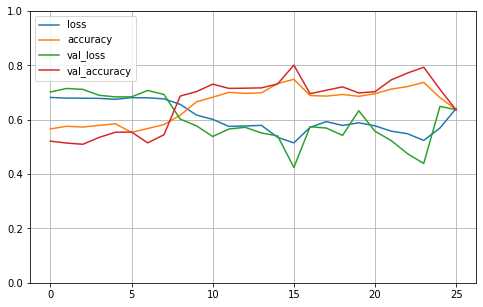

accuracy: 80.10%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 134s 341ms/step - loss: 0.6870 - accuracy: 0.5493 - val_loss: 0.6950 - val_accuracy: 0.5113


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 2/200
350/350 [==============================] - 116s 331ms/step - loss: 0.6808 - accuracy: 0.5702 - val_loss: 0.6920 - val_accuracy: 0.5268


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 3/200
350/350 [==============================] - 114s 326ms/step - loss: 0.6805 - accuracy: 0.5773 - val_loss: 0.6974 - val_accuracy: 0.5350


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 4/200
350/350 [==============================] - 115s 329ms/step - loss: 0.6798 - accuracy: 0.5806 - val_loss: 0.6993 - val_accuracy: 0.5202
Epoch 5/200
350/350 [==============================] - 117s 334ms/step - loss: 0.6748 - accuracy: 0.5814 - val_loss: 0.6935 - val_accuracy: 0.5390


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 6/200
350/350 [==============================] - 121s 346ms/step - loss: 0.6781 - accuracy: 0.5757 - val_loss: 0.7047 - val_accuracy: 0.5357
Epoch 7/200
350/350 [==============================] - 121s 347ms/step - loss: 0.6763 - accuracy: 0.5899 - val_loss: 0.6924 - val_accuracy: 0.5761


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 8/200
350/350 [==============================] - 122s 348ms/step - loss: 0.6765 - accuracy: 0.5852 - val_loss: 0.6531 - val_accuracy: 0.6208


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 9/200
350/350 [==============================] - 120s 344ms/step - loss: 0.6388 - accuracy: 0.6499 - val_loss: 0.6522 - val_accuracy: 0.6331


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 10/200
350/350 [==============================] - 118s 337ms/step - loss: 0.6376 - accuracy: 0.6492 - val_loss: 0.6104 - val_accuracy: 0.6850


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 11/200
350/350 [==============================] - 115s 328ms/step - loss: 0.6129 - accuracy: 0.6778 - val_loss: 0.6012 - val_accuracy: 0.6710
Epoch 12/200
350/350 [==============================] - 115s 329ms/step - loss: 0.5874 - accuracy: 0.6995 - val_loss: 0.5020 - val_accuracy: 0.7832


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 13/200
350/350 [==============================] - 113s 324ms/step - loss: 0.5304 - accuracy: 0.7421 - val_loss: 0.4606 - val_accuracy: 0.7819
Epoch 14/200
350/350 [==============================] - 114s 326ms/step - loss: 0.5031 - accuracy: 0.7567 - val_loss: 0.4307 - val_accuracy: 0.8086


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 15/200
350/350 [==============================] - 115s 328ms/step - loss: 0.5165 - accuracy: 0.7433 - val_loss: 0.5258 - val_accuracy: 0.7345
Epoch 16/200
350/350 [==============================] - 118s 338ms/step - loss: 0.5381 - accuracy: 0.7276 - val_loss: 0.4569 - val_accuracy: 0.7955
Epoch 17/200
350/350 [==============================] - 122s 349ms/step - loss: 0.5839 - accuracy: 0.6867 - val_loss: 0.5361 - val_accuracy: 0.7411
Epoch 18/200
350/350 [==============================] - 121s 345ms/step - loss: 0.5836 - accuracy: 0.7058 - val_loss: 0.5304 - val_accuracy: 0.7419
Epoch 19/200
350/350 [==============================] - 121s 347ms/step - loss: 0.5412 - accuracy: 0.7295 - val_loss: 0.4421 - val_accuracy: 0.7928
Epoch 20/200
350/350 [==============================] - 118s 338ms/step - loss: 0.4765 - accuracy: 0.7811 - val_loss: 0.3699 - val_accuracy: 0.8397


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 21/200
350/350 [==============================] - 116s 332ms/step - loss: 0.4364 - accuracy: 0.7996 - val_loss: 0.3693 - val_accuracy: 0.8469


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 22/200
350/350 [==============================] - 121s 347ms/step - loss: 0.4027 - accuracy: 0.8229 - val_loss: 0.3532 - val_accuracy: 0.8615


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 23/200
350/350 [==============================] - 121s 347ms/step - loss: 0.3941 - accuracy: 0.8264 - val_loss: 0.3842 - val_accuracy: 0.8433
Epoch 24/200
350/350 [==============================] - 122s 349ms/step - loss: 0.4106 - accuracy: 0.8170 - val_loss: 0.3896 - val_accuracy: 0.8325
Epoch 25/200
350/350 [==============================] - 122s 349ms/step - loss: 0.4490 - accuracy: 0.7904 - val_loss: 0.4173 - val_accuracy: 0.8301
Epoch 26/200
350/350 [==============================] - 122s 350ms/step - loss: 0.4324 - accuracy: 0.8040 - val_loss: 0.4684 - val_accuracy: 0.7729
Epoch 27/200
350/350 [==============================] - 121s 346ms/step - loss: 0.4348 - accuracy: 0.8006 - val_loss: 0.3478 - val_accuracy: 0.8566
Epoch 28/200
350/350 [==============================] - 119s 341ms/step - loss: 0.4108 - accuracy: 0.8138 - val_loss: 0.3253 - val_accuracy: 0.8584
Epoch 29/200
350/350 [==============================] - 122s 348ms/step - loss: 0.3741 - accuracy: 0.8354 - val_

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 30/200
350/350 [==============================] - 122s 348ms/step - loss: 0.3846 - accuracy: 0.8274 - val_loss: 0.2852 - val_accuracy: 0.8893


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.2.best/assets


Epoch 31/200
350/350 [==============================] - 123s 352ms/step - loss: 0.3535 - accuracy: 0.8510 - val_loss: 0.3166 - val_accuracy: 0.8644
Epoch 32/200
350/350 [==============================] - 124s 354ms/step - loss: 0.3839 - accuracy: 0.8315 - val_loss: 0.3696 - val_accuracy: 0.8401
Epoch 33/200
350/350 [==============================] - 124s 355ms/step - loss: 0.3962 - accuracy: 0.8248 - val_loss: 0.4458 - val_accuracy: 0.8014
Epoch 34/200
350/350 [==============================] - 124s 353ms/step - loss: 0.4192 - accuracy: 0.7989 - val_loss: 0.5749 - val_accuracy: 0.6934
Epoch 35/200
350/350 [==============================] - 123s 353ms/step - loss: 0.5747 - accuracy: 0.6964 - val_loss: 0.4882 - val_accuracy: 0.7511
Epoch 36/200
350/350 [==============================] - 124s 355ms/step - loss: 0.5145 - accuracy: 0.7439 - val_loss: 0.4138 - val_accuracy: 0.8151
Epoch 37/200
350/350 [==============================] - 124s 355ms/step - loss: 0.4851 - accuracy: 0.7637 - val_

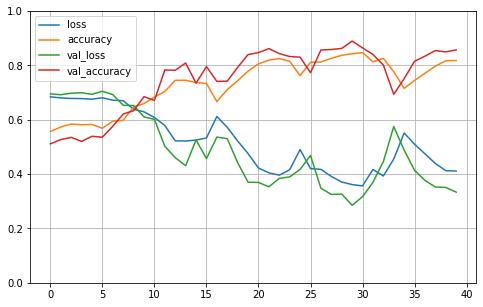

accuracy: 88.93%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 142s 364ms/step - loss: 0.6860 - accuracy: 0.5577 - val_loss: 0.6906 - val_accuracy: 0.5361


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 2/200
350/350 [==============================] - 123s 351ms/step - loss: 0.6801 - accuracy: 0.5655 - val_loss: 0.6914 - val_accuracy: 0.5162
Epoch 3/200
350/350 [==============================] - 125s 356ms/step - loss: 0.6818 - accuracy: 0.5779 - val_loss: 0.6988 - val_accuracy: 0.5000
Epoch 4/200
350/350 [==============================] - 131s 373ms/step - loss: 0.6988 - accuracy: 0.4950 - val_loss: 0.6975 - val_accuracy: 0.5000
Epoch 5/200
350/350 [==============================] - 134s 383ms/step - loss: 0.6919 - accuracy: 0.5199 - val_loss: 0.6937 - val_accuracy: 0.5172
Epoch 6/200
350/350 [==============================] - 135s 387ms/step - loss: 0.6813 - accuracy: 0.5634 - val_loss: 0.6952 - val_accuracy: 0.5233
Epoch 7/200
350/350 [==============================] - 133s 380ms/step - loss: 0.6690 - accuracy: 0.5933 - val_loss: 0.7005 - val_accuracy: 0.4996
Epoch 8/200
350/350 [==============================] - 132s 379ms/step - loss: 0.6947 - accuracy: 0.5155 - val_loss: 0

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 9/200
350/350 [==============================] - 136s 390ms/step - loss: 0.6801 - accuracy: 0.5812 - val_loss: 0.6329 - val_accuracy: 0.6344
Epoch 10/200
350/350 [==============================] - 135s 387ms/step - loss: 0.6623 - accuracy: 0.6030 - val_loss: 0.7024 - val_accuracy: 0.5152
Epoch 11/200
350/350 [==============================] - 137s 393ms/step - loss: 0.6739 - accuracy: 0.5879 - val_loss: 0.6679 - val_accuracy: 0.5839
Epoch 12/200
350/350 [==============================] - 136s 388ms/step - loss: 0.6241 - accuracy: 0.6559 - val_loss: 0.6003 - val_accuracy: 0.6783


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 13/200
350/350 [==============================] - 134s 383ms/step - loss: 0.6067 - accuracy: 0.6673 - val_loss: 0.5434 - val_accuracy: 0.7317


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 14/200
350/350 [==============================] - 132s 379ms/step - loss: 0.5935 - accuracy: 0.6844 - val_loss: 0.5677 - val_accuracy: 0.7065
Epoch 15/200
350/350 [==============================] - 133s 381ms/step - loss: 0.5829 - accuracy: 0.6916 - val_loss: 0.5159 - val_accuracy: 0.7560


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 16/200
350/350 [==============================] - 133s 381ms/step - loss: 0.5585 - accuracy: 0.7119 - val_loss: 0.4975 - val_accuracy: 0.7588


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 17/200
350/350 [==============================] - 134s 383ms/step - loss: 0.5512 - accuracy: 0.7186 - val_loss: 0.4771 - val_accuracy: 0.7694


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 18/200
350/350 [==============================] - 134s 384ms/step - loss: 0.5248 - accuracy: 0.7421 - val_loss: 0.4857 - val_accuracy: 0.7635
Epoch 19/200
350/350 [==============================] - 137s 391ms/step - loss: 0.5141 - accuracy: 0.7489 - val_loss: 0.4905 - val_accuracy: 0.7643
Epoch 20/200
350/350 [==============================] - 136s 390ms/step - loss: 0.5443 - accuracy: 0.7219 - val_loss: 0.4849 - val_accuracy: 0.7511
Epoch 21/200
350/350 [==============================] - 138s 396ms/step - loss: 0.5276 - accuracy: 0.7302 - val_loss: 0.5042 - val_accuracy: 0.7609
Epoch 22/200
350/350 [==============================] - 138s 394ms/step - loss: 0.5356 - accuracy: 0.7364 - val_loss: 0.3838 - val_accuracy: 0.8348


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 23/200
350/350 [==============================] - 138s 394ms/step - loss: 0.4515 - accuracy: 0.7904 - val_loss: 0.3586 - val_accuracy: 0.8458


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 24/200
350/350 [==============================] - 139s 397ms/step - loss: 0.4769 - accuracy: 0.7725 - val_loss: 0.4817 - val_accuracy: 0.7660
Epoch 25/200
350/350 [==============================] - 139s 397ms/step - loss: 0.5360 - accuracy: 0.7262 - val_loss: 0.4424 - val_accuracy: 0.7935
Epoch 26/200
350/350 [==============================] - 138s 395ms/step - loss: 0.5016 - accuracy: 0.7567 - val_loss: 0.4451 - val_accuracy: 0.7891
Epoch 27/200
350/350 [==============================] - 140s 399ms/step - loss: 0.4738 - accuracy: 0.7740 - val_loss: 0.3557 - val_accuracy: 0.8445
Epoch 28/200
350/350 [==============================] - 137s 392ms/step - loss: 0.4375 - accuracy: 0.8047 - val_loss: 0.4066 - val_accuracy: 0.8245
Epoch 29/200
350/350 [==============================] - 136s 390ms/step - loss: 0.4020 - accuracy: 0.8175 - val_loss: 0.4835 - val_accuracy: 0.7816
Epoch 30/200
350/350 [==============================] - 137s 390ms/step - loss: 0.4465 - accuracy: 0.7903 - val_

INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 33/200
350/350 [==============================] - 135s 385ms/step - loss: 0.3723 - accuracy: 0.8365 - val_loss: 0.2737 - val_accuracy: 0.8957


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 34/200
350/350 [==============================] - 135s 385ms/step - loss: 0.3832 - accuracy: 0.8303 - val_loss: 0.3080 - val_accuracy: 0.8741
Epoch 35/200
350/350 [==============================] - 138s 394ms/step - loss: 0.3758 - accuracy: 0.8321 - val_loss: 0.2768 - val_accuracy: 0.8896
Epoch 36/200
350/350 [==============================] - 139s 398ms/step - loss: 0.4092 - accuracy: 0.8155 - val_loss: 0.2666 - val_accuracy: 0.8965


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 37/200
350/350 [==============================] - 138s 394ms/step - loss: 0.3525 - accuracy: 0.8453 - val_loss: 0.2616 - val_accuracy: 0.8973


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 38/200
350/350 [==============================] - 139s 398ms/step - loss: 0.3520 - accuracy: 0.8534 - val_loss: 0.2640 - val_accuracy: 0.8981


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.3.best/assets


Epoch 39/200
350/350 [==============================] - 142s 406ms/step - loss: 0.3633 - accuracy: 0.8432 - val_loss: 0.2904 - val_accuracy: 0.8831
Epoch 40/200
350/350 [==============================] - 139s 398ms/step - loss: 0.4316 - accuracy: 0.7877 - val_loss: 0.4123 - val_accuracy: 0.8195
Epoch 41/200
350/350 [==============================] - 140s 400ms/step - loss: 0.4687 - accuracy: 0.7806 - val_loss: 0.3442 - val_accuracy: 0.8515
Epoch 42/200
350/350 [==============================] - 141s 404ms/step - loss: 0.4029 - accuracy: 0.8188 - val_loss: 0.3399 - val_accuracy: 0.8491
Epoch 43/200
350/350 [==============================] - 138s 396ms/step - loss: 0.3699 - accuracy: 0.8384 - val_loss: 0.2827 - val_accuracy: 0.8840
Epoch 44/200
350/350 [==============================] - 138s 395ms/step - loss: 0.3573 - accuracy: 0.8451 - val_loss: 0.2579 - val_accuracy: 0.8965
Epoch 45/200
350/350 [==============================] - 141s 402ms/step - loss: 0.3355 - accuracy: 0.8564 - val_

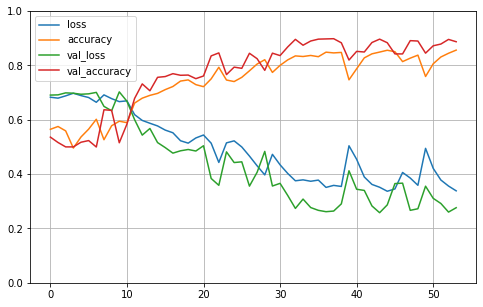

accuracy: 89.81%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 159s 400ms/step - loss: 0.6857 - accuracy: 0.5548 - val_loss: 0.6995 - val_accuracy: 0.5327


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 2/200
350/350 [==============================] - 137s 392ms/step - loss: 0.6801 - accuracy: 0.5781 - val_loss: 0.6977 - val_accuracy: 0.5322
Epoch 3/200
350/350 [==============================] - 141s 404ms/step - loss: 0.6772 - accuracy: 0.5879 - val_loss: 0.6954 - val_accuracy: 0.5230
Epoch 4/200
350/350 [==============================] - 146s 419ms/step - loss: 0.6735 - accuracy: 0.5869 - val_loss: 0.6952 - val_accuracy: 0.5404


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 5/200
350/350 [==============================] - 145s 415ms/step - loss: 0.6700 - accuracy: 0.5956 - val_loss: 0.6773 - val_accuracy: 0.5604


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 6/200
350/350 [==============================] - 148s 423ms/step - loss: 0.6727 - accuracy: 0.5837 - val_loss: 0.6934 - val_accuracy: 0.5226
Epoch 7/200
350/350 [==============================] - 150s 428ms/step - loss: 0.6845 - accuracy: 0.5550 - val_loss: 0.6880 - val_accuracy: 0.5424
Epoch 8/200
350/350 [==============================] - 149s 426ms/step - loss: 0.6739 - accuracy: 0.5840 - val_loss: 0.6994 - val_accuracy: 0.5691


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 9/200
350/350 [==============================] - 149s 426ms/step - loss: 0.6412 - accuracy: 0.6410 - val_loss: 0.5807 - val_accuracy: 0.7176


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 10/200
350/350 [==============================] - 153s 439ms/step - loss: 0.5781 - accuracy: 0.7079 - val_loss: 0.5292 - val_accuracy: 0.7586


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 11/200
350/350 [==============================] - 153s 437ms/step - loss: 0.5078 - accuracy: 0.7561 - val_loss: 0.4180 - val_accuracy: 0.8189


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 12/200
350/350 [==============================] - 145s 416ms/step - loss: 0.4894 - accuracy: 0.7730 - val_loss: 0.5407 - val_accuracy: 0.7351
Epoch 13/200
350/350 [==============================] - 144s 412ms/step - loss: 0.5138 - accuracy: 0.7530 - val_loss: 0.3850 - val_accuracy: 0.8355


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 14/200
350/350 [==============================] - 147s 419ms/step - loss: 0.4499 - accuracy: 0.7937 - val_loss: 0.3996 - val_accuracy: 0.8321
Epoch 15/200
350/350 [==============================] - 145s 415ms/step - loss: 0.4419 - accuracy: 0.7989 - val_loss: 0.3840 - val_accuracy: 0.8363


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 16/200
350/350 [==============================] - 140s 400ms/step - loss: 0.4261 - accuracy: 0.8087 - val_loss: 0.3565 - val_accuracy: 0.8486


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 17/200
350/350 [==============================] - 140s 402ms/step - loss: 0.4322 - accuracy: 0.8100 - val_loss: 0.3514 - val_accuracy: 0.8582


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.4.best/assets


Epoch 18/200
350/350 [==============================] - 141s 403ms/step - loss: 0.4084 - accuracy: 0.8188 - val_loss: 0.3535 - val_accuracy: 0.8551
Epoch 19/200
350/350 [==============================] - 142s 406ms/step - loss: 0.4092 - accuracy: 0.8168 - val_loss: 0.3938 - val_accuracy: 0.8328
Epoch 20/200
350/350 [==============================] - 139s 396ms/step - loss: 0.4422 - accuracy: 0.7926 - val_loss: 0.4472 - val_accuracy: 0.8051
Epoch 21/200
350/350 [==============================] - 142s 407ms/step - loss: 0.4761 - accuracy: 0.7675 - val_loss: 0.6260 - val_accuracy: 0.6366
Epoch 22/200
350/350 [==============================] - 143s 410ms/step - loss: 0.6120 - accuracy: 0.6473 - val_loss: 0.5685 - val_accuracy: 0.6921
Epoch 23/200
350/350 [==============================] - 146s 418ms/step - loss: 0.5668 - accuracy: 0.6923 - val_loss: 0.4421 - val_accuracy: 0.8048
Epoch 24/200
350/350 [==============================] - 148s 422ms/step - loss: 0.4954 - accuracy: 0.7619 - val_

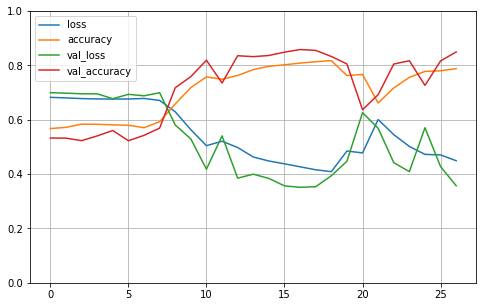

accuracy: 85.82%
COMPILE...
...COMPILED
FIT
Epoch 1/200
350/350 [==============================] - 168s 424ms/step - loss: 0.6854 - accuracy: 0.5567 - val_loss: 0.6930 - val_accuracy: 0.5113


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 2/200
350/350 [==============================] - 141s 403ms/step - loss: 0.6811 - accuracy: 0.5710 - val_loss: 0.7080 - val_accuracy: 0.5285


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 3/200
350/350 [==============================] - 144s 413ms/step - loss: 0.6824 - accuracy: 0.5728 - val_loss: 0.6924 - val_accuracy: 0.5272
Epoch 4/200
350/350 [==============================] - 140s 400ms/step - loss: 0.6822 - accuracy: 0.5512 - val_loss: 0.6979 - val_accuracy: 0.5359


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 5/200
350/350 [==============================] - 139s 396ms/step - loss: 0.6951 - accuracy: 0.5220 - val_loss: 0.6896 - val_accuracy: 0.5374


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 6/200
350/350 [==============================] - 140s 399ms/step - loss: 0.6925 - accuracy: 0.5225 - val_loss: 0.6872 - val_accuracy: 0.4999
Epoch 7/200
350/350 [==============================] - 139s 397ms/step - loss: 0.6878 - accuracy: 0.5380 - val_loss: 0.7061 - val_accuracy: 0.5217
Epoch 8/200
350/350 [==============================] - 137s 392ms/step - loss: 0.6770 - accuracy: 0.5898 - val_loss: 0.6428 - val_accuracy: 0.6523


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 9/200
350/350 [==============================] - 140s 399ms/step - loss: 0.6278 - accuracy: 0.6525 - val_loss: 0.5718 - val_accuracy: 0.7152


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 10/200
350/350 [==============================] - 142s 407ms/step - loss: 0.5808 - accuracy: 0.7024 - val_loss: 0.4600 - val_accuracy: 0.7821


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 11/200
350/350 [==============================] - 145s 414ms/step - loss: 0.5274 - accuracy: 0.7364 - val_loss: 0.5691 - val_accuracy: 0.7019
Epoch 12/200
350/350 [==============================] - 148s 424ms/step - loss: 0.5231 - accuracy: 0.7348 - val_loss: 0.4090 - val_accuracy: 0.8193


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 13/200
350/350 [==============================] - 147s 421ms/step - loss: 0.4524 - accuracy: 0.7899 - val_loss: 0.3837 - val_accuracy: 0.8370


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 14/200
350/350 [==============================] - 140s 399ms/step - loss: 0.4353 - accuracy: 0.8018 - val_loss: 0.3723 - val_accuracy: 0.8375


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


INFO:tensorflow:Assets written to: /content/drive/My Drive/data/JUNK2.cv.5.best/assets


Epoch 15/200
350/350 [==============================] - 141s 404ms/step - loss: 0.5176 - accuracy: 0.7452 - val_loss: 0.5435 - val_accuracy: 0.7283
Epoch 16/200
350/350 [==============================] - 144s 413ms/step - loss: 0.5703 - accuracy: 0.6999 - val_loss: 0.5458 - val_accuracy: 0.7128
Epoch 17/200
350/350 [==============================] - 143s 410ms/step - loss: 0.5768 - accuracy: 0.6894 - val_loss: 0.5350 - val_accuracy: 0.7267
Epoch 18/200
350/350 [==============================] - 143s 408ms/step - loss: 0.5522 - accuracy: 0.7182 - val_loss: 0.5199 - val_accuracy: 0.7362
Epoch 19/200
350/350 [==============================] - 140s 400ms/step - loss: 0.5598 - accuracy: 0.7043 - val_loss: 0.5298 - val_accuracy: 0.7305
Epoch 20/200
350/350 [==============================] - 142s 405ms/step - loss: 0.5839 - accuracy: 0.6950 - val_loss: 0.5911 - val_accuracy: 0.6951
Epoch 21/200
350/350 [==============================] - 143s 408ms/step - loss: 0.5895 - accuracy: 0.6888 - val_

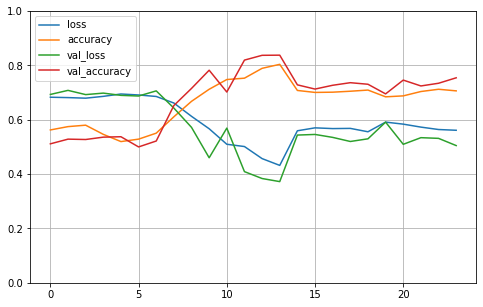

accuracy: 83.75%

5-way Cross Validation max 89.81%, mean 85.68% (+/- 3.54%)
Done


In [8]:
print ("Cross valiation")
do_cross_validation(X_train,y_train,model,X_valid,y_valid)  
print ("Done")